# Problem Statement

Our client wants to try to predict COVID-19 hotspots based on demographics and has asked us to build a predictive model that could predict if a county is a COVID-19 hotspot.  Since we are cautious about trying to predict an ongoing problem with many changes in real-time data, we informed that if our models don't meet a __.95 accuracy score or better__ that they should only use the model for interpretive purposes and not predictive purposes.  While the client understands the low likelihood of building a predictive model under this criteria, they gave us the budget to proceed anyway.

We defined a "COVID-19 hotspot" as a county in the contiguous US that has a rate of infected residents per capita that is higher than one standard deviation for the mean.  This actually presents an interesting situation where we already know that our baseline model will have an accuracy rate of .7625.  Due to this, we will only consider our model interpretable if we can beat the baseline accuracy.

We are viewing this as a classification problem and will look to run Logistic Regression, KNN, Support Vector Machine, Decision Tree Classifier, Bagging Classifier,Random Forest, and AdaBoost models in order to see if it's possible to predict COVID-19 hotspots based on county demographic data.

To reiterate, our goal for the model to be considered predictive is a __.95 accuracy score or better__, and our goal for the model to be considered interpretable is a __.7626 accuracy score or better__.  This is to ensure that we are held to high standards when it comes to predicting an ongoing pandemic, but also ensures that we can interpret the findings if we are performing better than average.



# Executive Summary

# Data Collection

In [1674]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.base import TransformerMixin
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.base import TransformerMixin # from Mahdi

import regex as re

random_state = 11

Data was initially pulled on May 8

In [1675]:
master = pd.read_csv('~/downloads/new_beds.csv')

In [1676]:
master = master.drop(columns = 'Unnamed: 0')

Master was the result of all of our cleaned dataframes merged into one, however we found some more specific area data after the fact, which is why we read in a separate dataframe.  We will have to do a little more cleaning.

In [1677]:
area = pd.read_csv('~/downloads/area_ready.csv')


In [1678]:
area = area.drop(columns = 'Unnamed: 0')

area.head()

,county,total_area,land_area,water_area
0,autauga county,1513895194,1539602155,2.570696e+07
1,baldwin county,2984648805,4117625664,1.132977e+09
2,barbour county,2241636927,2292160140,5.052321e+07
3,bibb county,1602558222,1612159622,9.601400e+06
4,blount county,1655136409,1670127873,1.499146e+07


# Cleaning/EDA

In [1679]:
master = pd.merge(area, master, how = 'left', on=area.index)

master.head()

,key_0,county,total_area,land_area,water_area,county_x,state,id,population,estimate!!race!!total population!!one race,...,"cert nurse midwvs,ft oth emptyp_y",nursing facilities total beds,nurse practitioners_y,"advpractnurs midwve,male w/npi",st_num,countyfips,beds,case_per_pop,beds_per_pop,beds_per_case
0,0,autauga county,1513895194,1539602155,2.570696e+07,autauga county,AL,1001,55200,54170,...,0.0,0.0,0.0,0.0,1,1001,85.0,0.001214,0.001540,1.268657
1,1,baldwin county,2984648805,4117625664,1.132977e+09,baldwin county,AL,1003,208107,204535,...,0.0,0.0,0.0,0.0,1,1003,386.0,0.000999,0.001855,1.855769
2,2,barbour county,2241636927,2292160140,5.052321e+07,barbour county,AL,1005,25782,25429,...,0.0,0.0,0.0,0.0,1,1005,74.0,0.002056,0.002870,1.396226
3,3,bibb county,1602558222,1612159622,9.601400e+06,bibb county,AL,1007,22527,22340,...,0.0,0.0,0.0,0.0,1,1007,35.0,0.001953,0.001554,0.795455
4,4,blount county,1655136409,1670127873,1.499146e+07,blount county,AL,1009,57645,56710,...,0.0,0.0,0.0,0.0,1,1009,25.0,0.000763,0.000434,0.568182


In [1773]:
master.isnull().sum().sort_values()

key_0                                 0
# hosp w/robotic surgery_x            0
# hosp w/ped cardiac electrophy       0
# hosp w/enabling services            0
short term community hosp beds_y      0
                                   ... 
skilled nurs care, beds set up_x      0
# veteran hosp, 006-049 beds_x        0
# veteran hosp, 300+ beds_x           0
licensed beds, short term hosp_x      0
beds_per_case                       103
Length: 942, dtype: int64

We are going to end up dropping beds per case when we set up our X & y variables because that would be technically leaking coronavirus data into our model, but for EDA purposes, it could be worth keeping around.  I'm more concerned investigating the water area null.

In [1681]:
master.loc[master['water_area'].isnull()]

,key_0,county,total_area,land_area,water_area,county_x,state,id,population,estimate!!race!!total population!!one race,...,"cert nurse midwvs,ft oth emptyp_y",nursing facilities total beds,nurse practitioners_y,"advpractnurs midwve,male w/npi",st_num,countyfips,beds,case_per_pop,beds_per_pop,beds_per_case
889,889,greeley county,2016057907,2016057907,NaN,greeley county,KS,20071,1200,1179,...,0.0,0.0,0.0,0.0,20,20071,18.0,0.0,0.015,inf


Since total area for Greeley County equals land area, I'm going to impute 0 for water area in this case.

In [1682]:
master['water_area'].replace({None: 0}, inplace = True)

master['pop_density'] = master['population'] / master['total_area']

In [1683]:
cens = master[master.columns[8:96]]

cens.shape

(3108, 88)

In [1684]:
ratios = []
for num in range(88):
    ratio = cens[cens.columns[num]]/ cens['population']
    ratios.append(ratio)
    

ratio_df = pd.DataFrame(ratios).T

ratio_df.columns =  cens.columns

ratio_df.columns = ratio_df.columns + ' ratio'

ratio_df.head()

,population ratio,estimate!!race!!total population!!one race ratio,estimate!!race!!total population!!two or more races ratio,estimate!!race!!total population!!one race.1 ratio,estimate!!race!!total population!!one race!!white ratio,estimate!!race!!total population!!one race!!black or african american ratio,estimate!!race!!total population!!one race!!american indian and alaska native ratio,estimate!!race!!total population!!one race!!american indian and alaska native!!cherokee tribal grouping ratio,estimate!!race!!total population!!one race!!american indian and alaska native!!chippewa tribal grouping ratio,estimate!!race!!total population!!one race!!american indian and alaska native!!navajo tribal grouping ratio,...,estimate!!sex and age!!total population!!21 years and over ratio,estimate!!sex and age!!total population!!62 years and over ratio,estimate!!sex and age!!total population!!65 years and over ratio,estimate!!sex and age!!total population!!18 years and over.1 ratio,estimate!!sex and age!!total population!!18 years and over!!male ratio,estimate!!sex and age!!total population!!18 years and over!!female ratio,estimate!!sex and age!!total population!!18 years and over!!sex ratio (males per 100 females) ratio,estimate!!sex and age!!total population!!65 years and over.1 ratio,estimate!!sex and age!!total population!!65 years and over!!male ratio,estimate!!sex and age!!total population!!65 years and over!!female ratio
0,1.0,0.981341,0.018659,0.981341,0.768786,0.191395,0.002880,0.001486,0.0,0.000797,...,0.717645,0.170344,0.145833,0.757808,0.363297,0.394511,0.001668,0.145833,0.063188,0.082645
1,1.0,0.982836,0.017164,0.982836,0.862662,0.094970,0.007314,0.001369,0.0,0.000336,...,0.747221,0.239353,0.195404,0.780512,0.375307,0.405205,0.000445,0.195404,0.090675,0.104730
2,1.0,0.986308,0.013692,0.986308,0.473819,0.475758,0.002793,0.001008,0.0,0.000349,...,0.752230,0.219455,0.179738,0.789155,0.423668,0.365488,0.004495,0.179738,0.077729,0.102009
3,1.0,0.991699,0.008301,0.991699,0.766547,0.222755,0.000355,0.000000,0.0,0.000000,...,0.748613,0.191903,0.162516,0.793182,0.425179,0.368003,0.005127,0.162516,0.072491,0.090025
4,1.0,0.983780,0.016220,0.983780,0.955052,0.014954,0.002446,0.000347,0.0,0.000000,...,0.732622,0.215110,0.177518,0.766363,0.374621,0.391743,0.001658,0.177518,0.078758,0.098760


In [1685]:
# ratio_df.to_csv('~/documents/population_ratios.csv')

In [1686]:
master = master.join(ratio_df)

In [1687]:
master['case_per_pop']

0       0.001214
1       0.000999
2       0.002056
3       0.001953
4       0.000763
          ...   
3103    0.000272
3104    0.002906
3105    0.000340
3106    0.000615
3107    0.000000
Name: case_per_pop, Length: 3108, dtype: float64

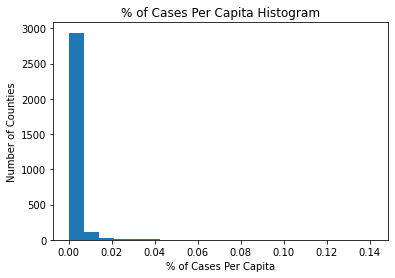

In [1688]:
plt.hist(master['case_per_pop'], bins = 20)
plt.title('% of Cases Per Capita Histogram')
plt.xlabel('% of Cases Per Capita')
plt.ylabel('Number of Counties');

In [1689]:
.95/2/2

0.2375

In [1690]:
master.shape[0] * 0.2375

738.15

In [1691]:
master.shape[0] - 739

2369

In [1692]:
above_std_1 = master.sort_values(by = 'case_per_pop', ascending = False).head(739)

This creates a list of counties that meet our criteria of a COVID-19 hotspot.

In [1693]:
above_std_1['case_per_pop'].sort_values().head(1)

2    0.002056
Name: case_per_pop, dtype: float64

This shows our cutoff point for our cases per population ratio.

In [1694]:
below = master.sort_values(by = 'case_per_pop', ascending = False).tail(2369)

In [1695]:
above_std_1['case_per_pop'] = ((above_std_1['case_per_pop'].values *0) +1).astype(int)

below['case_per_pop'] = ((below['case_per_pop'].values *0)).astype(int)

master['case_per_pop'] = pd.concat([above_std_1['case_per_pop'],below['case_per_pop']])
master.head()

,key_0,county,total_area,land_area,water_area,county_x,state,id,population,estimate!!race!!total population!!one race,...,estimate!!sex and age!!total population!!21 years and over ratio,estimate!!sex and age!!total population!!62 years and over ratio,estimate!!sex and age!!total population!!65 years and over ratio,estimate!!sex and age!!total population!!18 years and over.1 ratio,estimate!!sex and age!!total population!!18 years and over!!male ratio,estimate!!sex and age!!total population!!18 years and over!!female ratio,estimate!!sex and age!!total population!!18 years and over!!sex ratio (males per 100 females) ratio,estimate!!sex and age!!total population!!65 years and over.1 ratio,estimate!!sex and age!!total population!!65 years and over!!male ratio,estimate!!sex and age!!total population!!65 years and over!!female ratio
0,0,autauga county,1513895194,1539602155,2.570696e+07,autauga county,AL,1001,55200,54170,...,0.717645,0.170344,0.145833,0.757808,0.363297,0.394511,0.001668,0.145833,0.063188,0.082645
1,1,baldwin county,2984648805,4117625664,1.132977e+09,baldwin county,AL,1003,208107,204535,...,0.747221,0.239353,0.195404,0.780512,0.375307,0.405205,0.000445,0.195404,0.090675,0.104730
2,2,barbour county,2241636927,2292160140,5.052321e+07,barbour county,AL,1005,25782,25429,...,0.752230,0.219455,0.179738,0.789155,0.423668,0.365488,0.004495,0.179738,0.077729,0.102009
3,3,bibb county,1602558222,1612159622,9.601400e+06,bibb county,AL,1007,22527,22340,...,0.748613,0.191903,0.162516,0.793182,0.425179,0.368003,0.005127,0.162516,0.072491,0.090025
4,4,blount county,1655136409,1670127873,1.499146e+07,blount county,AL,1009,57645,56710,...,0.732622,0.215110,0.177518,0.766363,0.374621,0.391743,0.001658,0.177518,0.078758,0.098760


This takes our newly created 1 and 0 classifiers for our counties.

In [1696]:
# master.to_csv('~/documents/case_per_pop_dummied_std_1.csv')

# Model Preparation

In [1697]:
master['case_per_pop'].value_counts(normalize = True)

0    0.762227
1    0.237773
Name: case_per_pop, dtype: float64

Since we are using accuracy as our metric, our baseline is a score of .76227, which would occur if our model predicted an area to not be a coronavirus hotspot.

In [1698]:
X = master.drop(columns = ['total_covid', 'deaths', 'county_x', 'county_y', 'state', 'id', 'population', 
                           'case_per_pop', 'beds_per_case', 'unnamed: 0_y', 'st_num',
                           'cases', 'countyfips', 'key_0', 'county', 'population ratio'])
y = master['case_per_pop']


ss = StandardScaler()

X_ss = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_ss, y, random_state = 11, stratify = y)

In [1699]:
pipe = Pipeline([ #instantiate transformers and model
    ('lr', LogisticRegression(random_state = 11))
])

# set hyperparameters

pipe_params = {'lr__dual' : [True, False],
               'lr__class_weight' : ['dict', 'balanced', None],
              'lr__solver': ['liblinear', 'lbfgs', None],
              'lr__penalty': ['l1'] # running this with the lasso and ridge techniques by applying a penalty, also running with no penalty
              }

gs = GridSearchCV(pipe,
                 param_grid = pipe_params,
                 cv = 5,
                 scoring = 'accuracy',
                 verbose = 2   
                    )

In [1700]:
logreg_model = gs.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit fail

[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__so

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'd


[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr_

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError:

[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.1s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=l

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/pyt

[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=None, total=   0.0s
[CV] lr__class_weight

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)


[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   1.7s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   3.1s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   3.3s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   3.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   2.3s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l1, lr__

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError:


[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l1, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l1, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l1, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l1, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l1, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l1, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l1, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l1, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l1, lr__solver=

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)


[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   2.2s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   2.5s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   2.4s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   1.5s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   1.4s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l1, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_w

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   25.1s finished


In [1701]:
logreg_train_score = logreg_model.score(X_train, y_train)

In [1702]:
logreg_test_score = logreg_model.score(X_test, y_test)

In [1703]:
logreg_model.best_params_

{'lr__class_weight': None,
 'lr__dual': False,
 'lr__penalty': 'l1',
 'lr__solver': 'liblinear'}

In [1704]:
cross_val_score(logreg_model.best_estimator_, X_ss, y).mean()

0.7799374517814334

In [1705]:
coefs = logreg_model.best_estimator_.steps[0][1].coef_

coef_df = pd.DataFrame(coefs).T

coef_df['coefficients'] = list(X.columns)

coef_df.rename(columns=({0: 'coefficient',
                        'coefficients': 'feature'}), inplace=True)

coef_df.sort_values(by = 'coefficient')

,coefficient,feature
898,-2.832380,estimate!!sex and age!!total population!!sex r...
74,-2.310513,estimate!!sex and age!!total population!!75 to...
892,-1.369009,"estimate!!citizen, voting age population!!citi..."
19,-0.870766,estimate!!race!!total population!!one race!!as...
877,-0.804109,estimate!!hispanic or latino and race!!total p...
...,...,...
843,0.820850,estimate!!race!!total population!!one race!!bl...
46,1.027792,estimate!!hispanic or latino and race!!total p...
18,1.275108,estimate!!race!!total population!!one race!!as...
75,1.423399,estimate!!sex and age!!total population!!85 ye...


In [1706]:
logreg_model.best_estimator_

Pipeline(memory=None,
         steps=[('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l1', random_state=11,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [1707]:
logreg_train_score

0.8266838266838267

In [1708]:
logreg_test_score

0.8056628056628057

In [1709]:
coef_df['abs'] = abs(coef_df['coefficient'])

In [1710]:
lose_these = coef_df.loc[coef_df['abs'] < 0.0000001]

In [1711]:
# lose_these.to_csv('~/documents/bad_features.csv')

In [1712]:
list(lose_these['feature'].values)

['total_area',
 'estimate!!race!!total population!!one race',
 'estimate!!race!!total population!!two or more races',
 'estimate!!race!!total population!!one race.1',
 'estimate!!race!!total population!!one race!!white',
 'estimate!!race!!total population!!one race!!black or african american',
 'estimate!!race!!total population!!one race!!american indian and alaska native!!navajo tribal grouping',
 'estimate!!race!!total population!!one race!!asian',
 'estimate!!race!!total population!!one race!!asian!!chinese',
 'estimate!!race!!total population!!one race!!asian!!other asian',
 'estimate!!race!!total population!!one race!!native hawaiian and other pacific islander',
 'estimate!!race!!total population!!one race!!native hawaiian and other pacific islander!!native hawaiian',
 'estimate!!race!!total population!!one race!!some other race',
 'estimate!!race!!total population!!two or more races.1',
 'estimate!!race alone or in combination with one or more other races!!total population',
 'es

In [1713]:
better_master = master.drop(columns = list(lose_these['feature'].values))

In [1714]:
better_master.shape

(3108, 121)

In [1715]:
X = better_master.drop(columns = ['total_covid', 'deaths', 'county_x', 'county_y', 'state', 'id', 'population', 
                           'case_per_pop', 'beds_per_case', 'unnamed: 0_y','st_num', 'cases',
                                  'countyfips', 'key_0', 'county', 'population ratio'])
y = better_master['case_per_pop']


ss = StandardScaler()

X_ss = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_ss, y, random_state = 11, stratify = y)

In [1716]:
pipe = Pipeline([ #instantiate transformers and model
    ('lr', LogisticRegression(random_state = 11))
])

# set hyperparameters

pipe_params = {'lr__dual' : [True, False],
               'lr__class_weight' : ['dict', 'balanced', None],
              'lr__solver': ['liblinear', 'lbfgs', None],
              'lr__penalty': ['l1', 'l2', 'none'] # running this with the lasso and ridge techniques by applying a penalty, also running with no penalty
              }

gs = GridSearchCV(pipe,
                 param_grid = pipe_params,
                 cv = 5,
                 scoring = 'accuracy',
                 verbose = 2   
                    )

In [1717]:
logreg_2 = gs.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalt

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit fail


[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=True, lr__penalty=l2, lr__s

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: penalty='none' is not supported for the liblinear solver

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weigh

[CV]  lr__class_weight=dict, lr__dual=True, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__cla

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: class_weight must be dict, 'balanced', or None, got: 'dict'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in [

[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l1, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=d

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.3s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/l

[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.4s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: E

[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=dict, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l1, lr__solver=liblinear, total=   0.0s
[CV] lr__class_weight=balance

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.3s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.4s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.3s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.3s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only dual=False, got dual=True

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/e

[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.2s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)


[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   0.3s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   0.4s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   0.4s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   0.4s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   0.4s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.3s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.3s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.3s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_w

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.4s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/l

[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.3s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=balanced, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.3s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.3s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.4s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.2s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only dual=False, got dual=True

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/e

[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=liblinear, total=   0.2s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=True, lr__penalty=l2, lr__solver=lbfgs, total=   0.0s
[CV] lr__class_weight=None, lr__dual=True, lr__penalty=l2, 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)


[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   0.4s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   0.2s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   0.4s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   0.2s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=liblinear 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=liblinear, total=   0.3s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_w

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.2s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=l2, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=l2, 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/l

[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.1s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs 


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Logistic Regression supports only solvers in ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], got None.

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done 270 out of 270 | elap

[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=lbfgs, total=   0.3s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s
[CV] lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None 
[CV]  lr__class_weight=None, lr__dual=False, lr__penalty=none, lr__solver=None, total=   0.0s


/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [1718]:
logreg_2_train_score = logreg_2.score(X_train, y_train)

In [1719]:
logreg_2_test_score = logreg_2.score(X_test, y_test)

In [1720]:
logreg_2.best_params_

{'lr__class_weight': None,
 'lr__dual': True,
 'lr__penalty': 'l2',
 'lr__solver': 'liblinear'}

In [1721]:
cross_val_score(logreg_2.best_estimator_, X_ss, y).mean()

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/p

0.7815467221730328

In [1722]:
new_coefs = logreg_2.best_estimator_.steps[0][1].coef_

In [1723]:
new_coef_df = pd.DataFrame(new_coefs).T

In [1724]:
new_coef_df

,0
0,-0.026596
1,-0.036438
2,0.500673
3,-0.109867
4,0.152643
...,...
100,0.096917
101,0.315557
102,1.152635
103,-0.511083


In [1725]:
len(X.columns)

105

In [1726]:
new_coef_df['coefficients'] = list(X.columns)

In [1727]:
new_coef_df.rename(columns=({0: 'coefficient',
                        'coefficients': 'feature'}), inplace=True)

In [1728]:
new_coef_df.sort_values(by = 'coefficient')

,coefficient,feature
23,-1.892139,estimate!!sex and age!!total population!!75 to...
84,-1.730283,estimate!!sex and age!!total population!!sex r...
82,-1.216620,"estimate!!citizen, voting age population!!citi..."
25,-0.946003,estimate!!sex and age!!total population!!media...
10,-0.910530,estimate!!race!!total population!!one race!!as...
...,...,...
50,0.826362,estimate!!race!!total population!!one race!!bl...
19,1.011351,estimate!!hispanic or latino and race!!total p...
24,1.035937,estimate!!sex and age!!total population!!85 ye...
102,1.152635,estimate!!sex and age!!total population!!18 ye...


In [1729]:
new_coef_df[abs(new_coef_df['coefficient']) > .0000001]

,coefficient,feature
0,-0.026596,land_area
1,-0.036438,water_area
2,0.500673,estimate!!race!!total population!!one race!!am...
3,-0.109867,estimate!!race!!total population!!one race!!am...
4,0.152643,estimate!!race!!total population!!one race!!am...
...,...,...
100,0.096917,estimate!!sex and age!!total population!!18 ye...
101,0.315557,estimate!!sex and age!!total population!!18 ye...
102,1.152635,estimate!!sex and age!!total population!!18 ye...
103,-0.511083,estimate!!sex and age!!total population!!65 ye...


In [1730]:
logreg_2.best_estimator_

Pipeline(memory=None,
         steps=[('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=True,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=11,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [1731]:
print(f' Training Score: {logreg_2_train_score}')
print(f' Testing Score: {logreg_2_test_score}')



 Training Score: 0.8271128271128271
 Testing Score: 0.8018018018018018


# KNN Model

In [1732]:
pipe = Pipeline([
    ('knn', KNeighborsClassifier())])

# set hyperparameters

pipe_params = {
    'knn__n_neighbors': [3,5,7,9,27],
    'knn__weights' : ['uniform', 'distance'], # distance gives more predictive power to closer neighbors
    'knn__p': [1,2,'p'], # allows us to test Minkowski, Euclidean, and Manhattan measurements
               
              }

gsknn = GridSearchCV(pipe,
                 param_grid = pipe_params,
                 cv = 5,
                 scoring = 'accuracy',
                 verbose = 2
                    )

In [1733]:
knn_model = gsknn.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=uniform ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=uniform, total=   0.6s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=uniform ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=uniform, total=   0.5s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=uniform ..............
[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=uniform, total=   0.3s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=uniform ..............
[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=uniform, total=   0.4s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=uniform ..............
[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=uniform, total=   0.5s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=distance .............
[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=distance, total=   0.3s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=distance .............
[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=distance, total=   0.5s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=distance .............
[CV]  knn__n_neighbors=3, knn__p=1, knn__weights=distance, total=   0.5s
[CV] knn__n_neighbors=3, knn__p=1, knn__weights=distance ..........

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedW

[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=uniform, total=   0.5s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=uniform ..............
[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=uniform, total=   0.3s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=uniform ..............
[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=uniform, total=   0.3s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=uniform ..............
[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=uniform, total=   0.3s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=uniform ..............
[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=uniform, total=   0.4s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=distance .............
[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=distance, total=   0.2s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=distance .............
[CV]  knn__n_neighbors=5, knn__p=1, knn__weights=distance, total=   0.4s
[CV] knn__n_neighbors=5, knn__p=1, knn__weights=distance ...........

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedW

[CV]  knn__n_neighbors=7, knn__p=1, knn__weights=uniform, total=   0.5s
[CV] knn__n_neighbors=7, knn__p=1, knn__weights=uniform ..............
[CV]  knn__n_neighbors=7, knn__p=1, knn__weights=uniform, total=   0.4s
[CV] knn__n_neighbors=7, knn__p=1, knn__weights=uniform ..............
[CV]  knn__n_neighbors=7, knn__p=1, knn__weights=uniform, total=   0.3s
[CV] knn__n_neighbors=7, knn__p=1, knn__weights=uniform ..............
[CV]  knn__n_neighbors=7, knn__p=1, knn__weights=uniform, total=   0.4s
[CV] knn__n_neighbors=7, knn__p=1, knn__weights=uniform ..............
[CV]  knn__n_neighbors=7, knn__p=1, knn__weights=uniform, total=   0.4s
[CV] knn__n_neighbors=7, knn__p=1, knn__weights=distance .............
[CV]  knn__n_neighbors=7, knn__p=1, knn__weights=distance, total=   0.3s
[CV] knn__n_neighbors=7, knn__p=1, knn__weights=distance .............
[CV]  knn__n_neighbors=7, knn__p=1, knn__weights=distance, total=   0.4s
[CV] knn__n_neighbors=7, knn__p=1, knn__weights=distance ...........

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedW

[CV]  knn__n_neighbors=9, knn__p=1, knn__weights=uniform, total=   0.4s
[CV] knn__n_neighbors=9, knn__p=1, knn__weights=uniform ..............
[CV]  knn__n_neighbors=9, knn__p=1, knn__weights=uniform, total=   0.3s
[CV] knn__n_neighbors=9, knn__p=1, knn__weights=uniform ..............
[CV]  knn__n_neighbors=9, knn__p=1, knn__weights=uniform, total=   0.3s
[CV] knn__n_neighbors=9, knn__p=1, knn__weights=uniform ..............
[CV]  knn__n_neighbors=9, knn__p=1, knn__weights=uniform, total=   0.4s
[CV] knn__n_neighbors=9, knn__p=1, knn__weights=uniform ..............
[CV]  knn__n_neighbors=9, knn__p=1, knn__weights=uniform, total=   0.3s
[CV] knn__n_neighbors=9, knn__p=1, knn__weights=distance .............
[CV]  knn__n_neighbors=9, knn__p=1, knn__weights=distance, total=   0.3s
[CV] knn__n_neighbors=9, knn__p=1, knn__weights=distance .............
[CV]  knn__n_neighbors=9, knn__p=1, knn__weights=distance, total=   0.3s
[CV] knn__n_neighbors=9, knn__p=1, knn__weights=distance ...........

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedW

[CV]  knn__n_neighbors=27, knn__p=1, knn__weights=uniform, total=   0.4s
[CV] knn__n_neighbors=27, knn__p=1, knn__weights=uniform .............
[CV]  knn__n_neighbors=27, knn__p=1, knn__weights=uniform, total=   0.3s
[CV] knn__n_neighbors=27, knn__p=1, knn__weights=uniform .............
[CV]  knn__n_neighbors=27, knn__p=1, knn__weights=uniform, total=   0.5s
[CV] knn__n_neighbors=27, knn__p=1, knn__weights=uniform .............
[CV]  knn__n_neighbors=27, knn__p=1, knn__weights=uniform, total=   0.6s
[CV] knn__n_neighbors=27, knn__p=1, knn__weights=uniform .............
[CV]  knn__n_neighbors=27, knn__p=1, knn__weights=uniform, total=   0.3s
[CV] knn__n_neighbors=27, knn__p=1, knn__weights=distance ............
[CV]  knn__n_neighbors=27, knn__p=1, knn__weights=distance, total=   0.3s
[CV] knn__n_neighbors=27, knn__p=1, knn__weights=distance ............
[CV]  knn__n_neighbors=27, knn__p=1, knn__weights=distance, total=   0.3s
[CV] knn__n_neighbors=27, knn__p=1, knn__weights=distance ...

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<' not supported between instances of 'str' and 'int'

  FitFailedW

In [1734]:
knn_model.score(X_test, y_test)

0.8082368082368082

In [1735]:
knn_model.score(X_train, y_train)

0.8365508365508365

In [1736]:
knn_model.best_params_

{'knn__n_neighbors': 7, 'knn__p': 2, 'knn__weights': 'uniform'}

In [1737]:
cross_val_score(knn_model.best_estimator_, X_ss, y).mean()

0.7844323283160135

# SVM

In [1738]:
pipe = Pipeline([ #instantiate
    ('svc', SVC())])

# set hyperparameters

pipe_params = {
    'svc__kernel': ['linear', 'poly', 'rbf'],
    'svc__class_weight' : [dict, 'balanced'],
    'svc__random_state': [11],
    'svc__gamma' : ['scale', 'auto'],
    'svc__C' : [0, .5, 1],
    'svc__shrinking' : [True, False]
              }

gssvc = GridSearchCV(pipe,
                 param_grid = pipe_params,
                 cv = 5,
                 scoring = 'accuracy',
                 verbose = 2   
                    )

In [1739]:
svc_model = gssvc.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   0.1s
[CV] svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these

[CV]  svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=poly, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=poly, svc__random_state=11, svc__shrinking=False 
[CV]  svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=poly, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=rbf, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=rbf, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=rbf, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=rbf, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0, svc__class_weight=<class 'dict

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/p

[CV]  svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0, svc__class_weight=<cla

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/p

[CV]  svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=rbf, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=rbf, svc__random_state=11, svc__shrinking=False 
[CV]  svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=rbf, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=rbf, svc__random_state=11, svc__shrinking=False 
[CV]  svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=rbf, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=rbf, svc__random_state=11, svc__shrinking=False 
[CV]  svc__C=0, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=rbf, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0, svc__class_weight=<class 'dict'>, svc

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: C <= 0

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: C <= 0

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: C <= 0

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarni

[CV]  svc__C=0, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=poly, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=poly, svc__random_state=11, svc__shrinking=False 
[CV]  svc__C=0, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=poly, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=poly, svc__random_state=11, svc__shrinking=False 
[CV]  svc__C=0, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=poly, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=poly, svc__random_state=11, svc__shrinking=False 
[CV]  svc__C=0, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=poly, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=poly, 

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: C <= 0

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: C <= 0

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: C <= 0

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarni

[CV]  svc__C=0, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=False 
[CV]  svc__C=0, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=False 
[CV]  svc__C=0, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=False 
[CV]  svc__C=0, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=linear, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=l

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: C <= 0

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: C <= 0

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: C <= 0

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarni

[CV]  svc__C=0, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=rbf, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=rbf, svc__random_state=11, svc__shrinking=False 
[CV]  svc__C=0, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=rbf, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=rbf, svc__random_state=11, svc__shrinking=False 
[CV]  svc__C=0, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=rbf, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0.5, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0.5, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=linear, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0.5, svc__class_weight=<class 'dict'>, svc__gamma=scale, sv

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/p

[CV]  svc__C=0.5, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=rbf, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0.5, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=rbf, svc__random_state=11, svc__shrinking=False 
[CV]  svc__C=0.5, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=rbf, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0.5, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=rbf, svc__random_state=11, svc__shrinking=False 
[CV]  svc__C=0.5, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=rbf, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0.5, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=rbf, svc__random_state=11, svc__shrinking=False 
[CV]  svc__C=0.5, svc__class_weight=<class 'dict'>, svc__gamma=scale, svc__kernel=rbf, svc__random_state=11, svc__shrinking=False, total=   0.0s
[CV] svc__C=0.5, svc__class_wei

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/p

[CV]  svc__C=0.5, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=rbf, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0.5, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=rbf, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0.5, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=rbf, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0.5, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=rbf, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0.5, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=rbf, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0.5, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=rbf, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0.5, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=rbf, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=0.5, svc__class_weight=<class 'd

[CV]  svc__C=0.5, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=rbf, svc__random_state=11, svc__shrinking=True, total=   1.0s
[CV] svc__C=0.5, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=rbf, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0.5, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=rbf, svc__random_state=11, svc__shrinking=True, total=   0.9s
[CV] svc__C=0.5, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=rbf, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0.5, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=rbf, svc__random_state=11, svc__shrinking=True, total=   0.8s
[CV] svc__C=0.5, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=rbf, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0.5, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=rbf, svc__random_state=11, svc__shrinking=True, total=   0.8s
[CV] svc__C=0.5, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=rbf,

[CV]  svc__C=0.5, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=rbf, svc__random_state=11, svc__shrinking=True, total=   0.8s
[CV] svc__C=0.5, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=rbf, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=0.5, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=rbf, svc__random_state=11, svc__shrinking=True, total=   0.8s
[CV] svc__C=0.5, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=rbf, svc__random_state=11, svc__shrinking=False 
[CV]  svc__C=0.5, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=rbf, svc__random_state=11, svc__shrinking=False, total=   0.8s
[CV] svc__C=0.5, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=rbf, svc__random_state=11, svc__shrinking=False 
[CV]  svc__C=0.5, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=rbf, svc__random_state=11, svc__shrinking=False, total=   0.8s
[CV] svc__C=0.5, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=rbf, svc

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/p

/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: object of type 'type' has no len()

  FitFailedWarning)
/Users/brandongreenspan/opt/anaconda3/envs/dsi/lib/p

[CV]  svc__C=1, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=poly, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=1, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=poly, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=1, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=poly, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=1, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=poly, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=1, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=poly, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=1, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=poly, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=1, svc__class_weight=<class 'dict'>, svc__gamma=auto, svc__kernel=poly, svc__random_state=11, svc__shrinking=True, total=   0.0s
[CV] svc__C=1, svc__class_weight=<class 'dict'>, sv

[CV]  svc__C=1, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=poly, svc__random_state=11, svc__shrinking=True, total=   1.2s
[CV] svc__C=1, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=poly, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=1, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=poly, svc__random_state=11, svc__shrinking=True, total=   1.0s
[CV] svc__C=1, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=poly, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=1, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=poly, svc__random_state=11, svc__shrinking=True, total=   0.9s
[CV] svc__C=1, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=poly, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=1, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=poly, svc__random_state=11, svc__shrinking=True, total=   0.7s
[CV] svc__C=1, svc__class_weight=balanced, svc__gamma=scale, svc__kernel=poly, svc__ra

[CV]  svc__C=1, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=poly, svc__random_state=11, svc__shrinking=True, total=   1.0s
[CV] svc__C=1, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=poly, svc__random_state=11, svc__shrinking=True 
[CV]  svc__C=1, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=poly, svc__random_state=11, svc__shrinking=True, total=   0.9s
[CV] svc__C=1, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=poly, svc__random_state=11, svc__shrinking=False 
[CV]  svc__C=1, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=poly, svc__random_state=11, svc__shrinking=False, total=   1.1s
[CV] svc__C=1, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=poly, svc__random_state=11, svc__shrinking=False 
[CV]  svc__C=1, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=poly, svc__random_state=11, svc__shrinking=False, total=   0.9s
[CV] svc__C=1, svc__class_weight=balanced, svc__gamma=auto, svc__kernel=poly, svc__random

[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  2.9min finished


In [1740]:
svc_model.score(X_test, y_test)

0.8056628056628057

In [1741]:
svc_model.score(X_train, y_train)

0.8412698412698413

In [1742]:
svc_model.best_params_

{'svc__C': 1,
 'svc__class_weight': 'balanced',
 'svc__gamma': 'scale',
 'svc__kernel': 'poly',
 'svc__random_state': 11,
 'svc__shrinking': True}

In [1743]:
new_coef_df.sort_values(by = 'coefficient')

,coefficient,feature
23,-1.892139,estimate!!sex and age!!total population!!75 to...
84,-1.730283,estimate!!sex and age!!total population!!sex r...
82,-1.216620,"estimate!!citizen, voting age population!!citi..."
25,-0.946003,estimate!!sex and age!!total population!!media...
10,-0.910530,estimate!!race!!total population!!one race!!as...
...,...,...
50,0.826362,estimate!!race!!total population!!one race!!bl...
19,1.011351,estimate!!hispanic or latino and race!!total p...
24,1.035937,estimate!!sex and age!!total population!!85 ye...
102,1.152635,estimate!!sex and age!!total population!!18 ye...


In [1744]:
coef_df['actual_odds'] = np.exp(coef_df['coefficient'])

In [1745]:
new_coef_df['actual_odds'] = np.exp(new_coef_df['coefficient'])

In [1746]:
coef_df

,coefficient,feature,abs,actual_odds
0,0.000000,total_area,0.000000,1.000000
1,-0.007882,land_area,0.007882,0.992149
2,-0.014013,water_area,0.014013,0.986085
3,0.000000,estimate!!race!!total population!!one race,0.000000,1.000000
4,0.000000,estimate!!race!!total population!!two or more ...,0.000000,1.000000
...,...,...,...,...
921,0.199238,estimate!!sex and age!!total population!!18 ye...,0.199238,1.220473
922,2.130722,estimate!!sex and age!!total population!!18 ye...,2.130722,8.420946
923,0.000000,estimate!!sex and age!!total population!!65 ye...,0.000000,1.000000
924,-0.614837,estimate!!sex and age!!total population!!65 ye...,0.614837,0.540729


In [1747]:
new_coef_df

,coefficient,feature,actual_odds
0,-0.026596,land_area,0.973755
1,-0.036438,water_area,0.964218
2,0.500673,estimate!!race!!total population!!one race!!am...,1.649831
3,-0.109867,estimate!!race!!total population!!one race!!am...,0.895953
4,0.152643,estimate!!race!!total population!!one race!!am...,1.164909
...,...,...,...
100,0.096917,estimate!!sex and age!!total population!!18 ye...,1.101769
101,0.315557,estimate!!sex and age!!total population!!18 ye...,1.371022
102,1.152635,estimate!!sex and age!!total population!!18 ye...,3.166526
103,-0.511083,estimate!!sex and age!!total population!!65 ye...,0.599845


In [1748]:
lasso_eval = coef_df.loc[coef_df['coefficient'] != 0].sort_values(by = 'coefficient')

In [1749]:
#lasso_eval.to_csv('~/documents/lasso_coef.csv')

In [1750]:
logreg2_eval = new_coef_df.loc[new_coef_df['coefficient'] != 0].sort_values(by = 'coefficient')

In [1751]:
#logreg2_eval.to_csv('~/documents/logreg_coefs.csv')

In [1752]:
# master.to_csv('~/documents/master_w_ratios.csv')

In [1753]:
# better_master.to_csv('~/documents/lassoed_df.csv')

In [1754]:
better_master

,key_0,county,land_area,water_area,county_x,state,id,population,estimate!!race!!total population!!one race!!american indian and alaska native,estimate!!race!!total population!!one race!!american indian and alaska native!!cherokee tribal grouping,...,estimate!!sex and age!!total population!!median age (years) ratio,estimate!!sex and age!!total population!!under 18 years ratio,estimate!!sex and age!!total population!!16 years and over ratio,estimate!!sex and age!!total population!!18 years and over ratio,estimate!!sex and age!!total population!!21 years and over ratio,estimate!!sex and age!!total population!!18 years and over.1 ratio,estimate!!sex and age!!total population!!18 years and over!!female ratio,estimate!!sex and age!!total population!!18 years and over!!sex ratio (males per 100 females) ratio,estimate!!sex and age!!total population!!65 years and over!!male ratio,estimate!!sex and age!!total population!!65 years and over!!female ratio
0,0,autauga county,1539602155,2.570696e+07,autauga county,AL,1001,55200,159,82,...,0.000685,0.242192,0.785652,0.757808,0.717645,0.757808,0.394511,0.001668,0.063188,0.082645
1,1,baldwin county,4117625664,1.132977e+09,baldwin county,AL,1003,208107,1522,285,...,0.000206,0.219488,0.805893,0.780512,0.747221,0.780512,0.405205,0.000445,0.090675,0.104730
2,2,barbour county,2292160140,5.052321e+07,barbour county,AL,1005,25782,72,26,...,0.001548,0.210845,0.812505,0.789155,0.752230,0.789155,0.365488,0.004495,0.077729,0.102009
3,3,bibb county,1612159622,9.601400e+06,bibb county,AL,1007,22527,8,0,...,0.001771,0.206818,0.819905,0.793182,0.748613,0.793182,0.368003,0.005127,0.072491,0.090025
4,4,blount county,1670127873,1.499146e+07,blount county,AL,1009,57645,141,20,...,0.000708,0.233637,0.796513,0.766363,0.732622,0.766363,0.391743,0.001658,0.078758,0.098760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3103,3103,sweetwater county,27005754251,1.662303e+08,sweetwater county,WY,56037,44117,742,0,...,0.000784,0.267675,0.760002,0.732325,0.691139,0.732325,0.351520,0.002455,0.051273,0.055738
3104,3104,teton county,10351790056,5.708591e+08,teton county,WY,56039,23059,77,30,...,0.001704,0.192289,0.823236,0.807711,0.787935,0.807711,0.390563,0.004632,0.066178,0.069778
3105,3105,uinta county,5391631764,1.662582e+07,uinta county,WY,56041,20609,160,0,...,0.001723,0.294580,0.736377,0.705420,0.676355,0.705420,0.352176,0.004867,0.059877,0.061332
3106,3106,washakie county,5798138761,1.042960e+07,washakie county,WY,56043,8129,52,42,...,0.005351,0.238898,0.806618,0.761102,0.732070,0.761102,0.374585,0.012695,0.097675,0.109731


In [1755]:
new_coef_df.shape

(105, 3)

In [1756]:
# new_coef_df.to_csv('~/documents/top_55.csv')

# Decision Tree Classifier

In [1757]:
dt_pipe = Pipeline([
    ('dt' ,DecisionTreeClassifier())
])
pipe_params = {
    'dt__max_depth' : [10],
    'dt__min_samples_leaf' : [8],
    'dt__min_samples_split' : [3],
    }
gs = GridSearchCV(dt_pipe, # what object are we optimizing?
                  param_grid=pipe_params,
                  n_jobs = -1,# what parameters values are we searching?
                  cv=StratifiedKFold(shuffle=True)
                  ,
                  verbose = 2) # 3-fold cross-validation.
gs.fit(X_train,y_train)
gs.best_params_
print(f'Train Score {gs.score(X_train,y_train)}')
print(f'Test Score {gs.score(X_test,y_test)}')
print(f'Cross Val Score {cross_val_score(gs.best_estimator_, X,y).mean()}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.7s finished


Train Score 0.894036894036894
Test Score 0.7709137709137709
Cross Val Score 0.7503274979159222


# Bagging Classifier

In [1758]:
bag_pipe = Pipeline([
    ('bag', BaggingClassifier())])
pipe_params = {
    'bag__n_estimators': [50],
    'bag__max_features': [.9]
    }
gs = GridSearchCV(bag_pipe, # what object are we optimizing?
                  param_grid=pipe_params,
                  n_jobs = -1,# what parameters values are we searching?
                  cv=StratifiedKFold(shuffle=True),
                  verbose = 2) # 3-fold cross-validation.
gs.fit(X_train,y_train)
print(f'Train Score {gs.score(X_train,y_train)}')
print(f'Test Score {gs.score(X_test,y_test)}')
print(f'Cross Val Score {cross_val_score(gs.best_estimator_, X,y).mean()}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.0s finished


Train Score 0.9987129987129987
Test Score 0.8198198198198198
Cross Val Score 0.7944136363401009


# Random Forest Classifier

In [1759]:
rf_pipe = Pipeline([
    ('rf', RandomForestClassifier())])
rf_params = {
    'rf__max_depth':[5,10],
    'rf__n_estimators':[20,25,30]
}
gs = GridSearchCV(rf_pipe, param_grid=rf_params, cv=5,verbose=50)
gs.fit(X_train, y_train)
print(f'Train Score {gs.score(X_train,y_train)}')
print(f'Test Score {gs.score(X_test,y_test)}')
print(f'Cross Val Score {cross_val_score(gs.best_estimator_, X,y).mean()}')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] rf__max_depth=5, rf__n_estimators=20 ............................
[CV]  rf__max_depth=5, rf__n_estimators=20, score=0.790, total=   0.3s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[CV] rf__max_depth=5, rf__n_estimators=20 ............................
[CV]  rf__max_depth=5, rf__n_estimators=20, score=0.809, total=   0.2s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[CV] rf__max_depth=5, rf__n_estimators=20 ............................
[CV]  rf__max_depth=5, rf__n_estimators=20, score=0.796, total=   0.4s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s
[CV] rf__max_depth=5, rf__n_estimators=20 ............................
[CV]  rf__max_depth=5, rf__n_estimators=20, score=0.779, total=   0.3s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed

# Adaboost

In [1760]:
ada_pipe = Pipeline([
    ('ada', AdaBoostClassifier())])
ada_params = {
    'ada__n_estimators' : [250],
    'ada__learning_rate' : [1.5]
    }
gs = GridSearchCV(ada_pipe, param_grid=ada_params, cv=StratifiedKFold(shuffle=True),verbose=12, n_jobs=-1)
gs.fit(X_train, y_train)
print(f'Train Score {gs.score(X_train,y_train)}')
print(f'Test Score {gs.score(X_test,y_test)}')
print(f'Cross Val Score {cross_val_score(gs.best_estimator_, X,y).mean()}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   14.5s remaining:   21.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   14.5s remaining:    9.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.6s finished


Train Score 0.9317889317889317
Test Score 0.752895752895753
Cross Val Score 0.7374647260149846


# Model Evaluation

In [1761]:
X = master.drop(columns = ['total_covid', 'deaths', 'county_x', 'county_y', 'state', 'id', 'population', 
                           'case_per_pop', 'beds_per_case', 'unnamed: 0_y', 'st_num',
                           'cases', 'countyfips', 'key_0', 'county', 'population ratio'])
y = master['case_per_pop']


ss = StandardScaler()

X_ss = ss.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_ss, y, random_state = 11, stratify = y)

In [1762]:
logreg_preds = logreg_model.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, logreg_preds).ravel() # From Danielle Medellin's confusion matrix setup
cm = confusion_matrix(y_test, logreg_preds)

In [1763]:
cm

array([[553,  39],
       [112,  73]])

In [1764]:
cm_df = pd.DataFrame(cm)
cm_df.columns = ['Non-Hotspot Prediction', 'Hotspot Prediction']

cm_df.index = ['Actual Non-Hotspot', "Actual Hotspot"]
#This adds the appropriate row and column names for the confusion matrix

cm_df

,Non-Hotspot Prediction,Hotspot Prediction
Actual Non-Hotspot,553,39
Actual Hotspot,112,73


In [1765]:
(73 + 553)/(626 + 112 +39)

0.8056628056628057

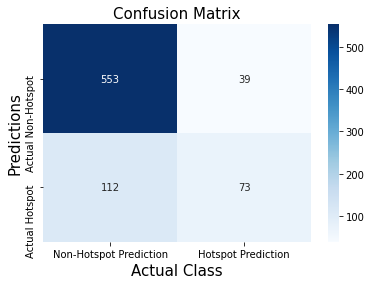

In [1766]:
sns.heatmap(cm_df, annot = True, fmt = 'g', cmap = 'Blues')
plt.title('Confusion Matrix', size = 15)
plt.ylabel('Predictions', size = 15)
plt.xlabel('Actual Class', size = 15);

In [1767]:
accuracy = (tp + tn)/(tp+fn+fp+tn)
print(f'Accuracy Rate: {accuracy}')

sensitivity = tp/(tp+fn)
print(f'Sensitivity Rate: {sensitivity}')
            
specificity = tn/(tn+fp)
print(f'Specificity Rate: {specificity}')

precision = tp/(tp+fp)
print(f'Precision Rate: {precision}')

true_neg = tn/(tn+fn)
print(f'True Negative Rate: {true_neg}')

Accuracy Rate: 0.8056628056628057
Sensitivity Rate: 0.3945945945945946
Specificity Rate: 0.9341216216216216
Precision Rate: 0.6517857142857143
True Negative Rate: 0.8315789473684211


In [1768]:
coef_df

,coefficient,feature,abs,actual_odds
0,0.000000,total_area,0.000000,1.000000
1,-0.007882,land_area,0.007882,0.992149
2,-0.014013,water_area,0.014013,0.986085
3,0.000000,estimate!!race!!total population!!one race,0.000000,1.000000
4,0.000000,estimate!!race!!total population!!two or more ...,0.000000,1.000000
...,...,...,...,...
921,0.199238,estimate!!sex and age!!total population!!18 ye...,0.199238,1.220473
922,2.130722,estimate!!sex and age!!total population!!18 ye...,2.130722,8.420946
923,0.000000,estimate!!sex and age!!total population!!65 ye...,0.000000,1.000000
924,-0.614837,estimate!!sex and age!!total population!!65 ye...,0.614837,0.540729


In [1769]:
fp_counties = y_test.loc[(y_test != 1) & (logreg_preds == 1)].index #shows me misclassified rows



In [1770]:
fp_df = master.loc[master.index[fp_counties]]

In [1771]:
fp_df.sort_values(by = 'population', ascending = False)

,key_0,county,total_area,land_area,water_area,county_x,state,id,population,estimate!!race!!total population!!one race,...,estimate!!sex and age!!total population!!21 years and over ratio,estimate!!sex and age!!total population!!62 years and over ratio,estimate!!sex and age!!total population!!65 years and over ratio,estimate!!sex and age!!total population!!18 years and over.1 ratio,estimate!!sex and age!!total population!!18 years and over!!male ratio,estimate!!sex and age!!total population!!18 years and over!!female ratio,estimate!!sex and age!!total population!!18 years and over!!sex ratio (males per 100 females) ratio,estimate!!sex and age!!total population!!65 years and over.1 ratio,estimate!!sex and age!!total population!!65 years and over!!male ratio,estimate!!sex and age!!total population!!65 years and over!!female ratio
338,338,orange county,2073171585,2335738262,2.625667e+08,orange county,FL,12095,1321194,1276729,...,0.729455,0.142672,0.113733,0.775147,0.376136,0.399012,0.000071,0.113733,0.049625,0.064109
2549,2549,denton county,2085807196,2275298676,1.894915e+08,denton county,TX,48121,807047,778441,...,0.703452,0.121998,0.094994,0.745893,0.362064,0.383829,0.000117,0.094994,0.042374,0.052620
1897,1897,bernalillo county,1857553267,1874472931,1.691966e+07,bernalillo county,NM,35001,677692,649178,...,0.736903,0.188000,0.152296,0.776331,0.376063,0.400267,0.000139,0.152296,0.067253,0.085043
354,354,volusia county,1994708722,2852352391,8.576437e+08,volusia county,FL,12127,527634,517240,...,0.783706,0.282095,0.237866,0.821262,0.396595,0.424667,0.000177,0.237866,0.108350,0.129516
347,347,seminole county,2078809884,2622105608,5.432957e+08,seminole county,FL,12117,455086,440178,...,0.750869,0.183163,0.148242,0.787122,0.375327,0.411795,0.000200,0.148242,0.063926,0.084316
1298,1298,dakota county,1394107452,1456967351,6.285990e+07,dakota county,MN,27037,418201,403644,...,0.720488,0.163235,0.131147,0.753092,0.365850,0.387242,0.000226,0.131147,0.057977,0.073171
2291,2291,charleston county,1237819592,2377478103,1.139659e+09,charleston county,SC,45019,394708,386707,...,0.762495,0.190698,0.154365,0.800827,0.382787,0.418041,0.000232,0.154365,0.067711,0.086654
126,126,pulaski county,1838109640,1964339775,1.262301e+08,pulaski county,AR,5119,393463,382492,...,0.730727,0.182505,0.144837,0.765477,0.359442,0.406036,0.000225,0.144837,0.061490,0.083347
339,339,osceola county,2976496907,3438557597,4.620607e+08,osceola county,FL,12097,338619,325112,...,0.713560,0.158745,0.127542,0.751948,0.365493,0.386455,0.000279,0.127542,0.056801,0.070740
2055,2055,lorain county,152700424,1272195481,1.119495e+09,lorain county,OH,39093,306713,295480,...,0.735707,0.212159,0.172963,0.775689,0.377297,0.398392,0.000309,0.172963,0.076019,0.096944


In [1772]:
# fp_df.to_csv('~/documents/false_positives.csv')